# Etude consommation moyenne brute par heure de gaz et d'électricité

La base de données provient de l'URL: 
https://www.data.gouv.fr/fr/datasets/consommation-quotidienne-brute/

Petit descriptif de la database demi-heure par demi-heure: 
- consommation en éléctricité enn MW
- consommation de gaz en MW
- statut

Information sur le nucléaire français:
https://www.edf.fr/groupe-edf/espaces-dedies/l-energie-de-a-a-z/tout-sur-l-energie/produire-de-l-electricite/le-nucleaire-en-chiffres

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# Download and clean data

La base données provient directement du site data.gouv.fr. Nous avons dans celui-ci près de 200 000 lignes représentant les consommations d'électricité et de gaz demi-heure par demi-heure depuis 2012. 

La base de données contient 11 colonnes : 
- date-heure
- date
- heure
- consommation brute gaz grtgaz (en MW)
- statut grtgaz
- consommation brute gaz terega (en MW)
- statut terega
- consommation brute gaz totale (en MW)
- consommation brute électricité RTE (en MW)
- statut RTE
- consommation brute totale


In [2]:
# download data
raw_data = pd.read_csv("./raw_daily_conso.csv", sep=';')

# drop rows too recent that does not contain enough data (01/06/2022)
index_max = raw_data.loc[raw_data.date == '01/06/2022'].index.max()
i_to_drop = [i for i in range(index_max+1)]
raw_data.drop(labels=i_to_drop, axis=0, inplace=True)

# now drop column date_heure (redundant)
raw_data.drop(columns=['date_heure'], inplace=True)

# show state of data
raw_data.head(6)


,date,heure,consommation_brute_gaz_grtgaz,statut_grtgaz,consommation_brute_gaz_terega,statut_terega,consommation_brute_gaz_totale,consommation_brute_electricite_rte,statut_rte,consommation_brute_totale
10271,31/05/2022,23:30,NaN,NaN,NaN,NaN,NaN,45279.0,Consolidé,NaN
10272,31/05/2022,23:00,27364.0,Définitif,1164.0,Définitif,28528.0,46703.0,Consolidé,75231.0
10273,31/05/2022,22:30,NaN,NaN,NaN,NaN,NaN,45067.0,Consolidé,NaN
10274,31/05/2022,22:00,28613.0,Définitif,1218.0,Définitif,29831.0,44019.0,Consolidé,73850.0
10275,31/05/2022,21:30,NaN,NaN,NaN,NaN,NaN,44043.0,Consolidé,NaN
10276,31/05/2022,21:00,29989.0,Définitif,1328.0,Définitif,31317.0,44677.0,Consolidé,75994.0


In [3]:
# check types of dataframe 
raw_data.dtypes

date                                   object
heure                                  object
consommation_brute_gaz_grtgaz         float64
statut_grtgaz                          object
consommation_brute_gaz_terega         float64
statut_terega                          object
consommation_brute_gaz_totale         float64
consommation_brute_electricite_rte    float64
statut_rte                             object
consommation_brute_totale             float64
dtype: object

In [4]:
data_hh = raw_data  # keep raw data

# notice that row '05/012/2020 - 00:0' is present twice : fix
data_hh.at[36334, 'date'] = '06/12/2020'

# change types of columns date and heure
data_hh['date'] = pd.to_datetime(data_hh['date'], dayfirst=True)
data_hh['heure'] = pd.to_datetime(data_hh['heure'], format='%H:%M') \
                   - pd.to_datetime(data_hh['heure'], format='%H:%M').dt.normalize()
    
raw_data.dtypes

date                                   datetime64[ns]
heure                                 timedelta64[ns]
consommation_brute_gaz_grtgaz                 float64
statut_grtgaz                                  object
consommation_brute_gaz_terega                 float64
statut_terega                                  object
consommation_brute_gaz_totale                 float64
consommation_brute_electricite_rte            float64
statut_rte                                     object
consommation_brute_totale                     float64
dtype: object

In [5]:
# sort rows by date and hour
data_hh.sort_values(by=['date', 'heure'], inplace=True)
data_hh.reset_index(drop=True, inplace=True)

In [6]:
len(pd.unique(data_hh.loc[data_hh.index % 2 == 1].heure))

24

In [7]:
# first transformation to apply
def transformation_1(row):
    if row.name % 2 == 1:
        return row.consommation_brute_electricite_rte
    i = row.name
    to_add = data_hh.at[i+1, 'consommation_brute_electricite_rte'] 
    conso_hph = (row.consommation_brute_electricite_rte + to_add) / 2
    return conso_hph

data_hh['consommation_brute_electricite_rte_hph'] = data_hh.apply(func=transformation_1, axis=1)

# drop half of rows (useless for hour per hour dataset)
labels_to_drop = [i
                  for i in range(data_hh.index.min(), data_hh.index.max()+1)
                  if i % 2 == 1]
data_hh = data_hh.drop(labels=labels_to_drop, axis=0)


In [8]:
# second transformation to apply 
def transformation_2(row):
    gaz = row.consommation_brute_gaz_totale
    electricite = row.consommation_brute_electricite_rte_hph
    return gaz + electricite

data_hh['consommation_brute_totale_hph'] = data_hh.apply(func=transformation_2, 
                                                         axis=1)

# drop useless columns 
columns_to_drop = ['consommation_brute_electricite_rte', 
                   'consommation_brute_totale', 
                   'statut_terega', 
                   'statut_grtgaz', 
                   'statut_rte']
data_hh.drop(columns=columns_to_drop, inplace=True)

In [9]:
# change type of column date
data_hh['date'] = pd.to_datetime(data_hh['date'], dayfirst=True)

# now reset index of dataframe and show 
data_hh.reset_index(inplace=True, drop=True)
data_hh.head()

,date,heure,consommation_brute_gaz_grtgaz,consommation_brute_gaz_terega,consommation_brute_gaz_totale,consommation_brute_electricite_rte_hph,consommation_brute_totale_hph
0,2012-01-01,0 days 00:00:00,52099.0,3254.0,55353.0,58962.0,114315.0
1,2012-01-01,0 days 01:00:00,52236.0,3208.0,55444.0,56152.5,111596.5
2,2012-01-01,0 days 02:00:00,52251.0,3214.0,55465.0,55221.0,110686.0
3,2012-01-01,0 days 03:00:00,52836.0,3212.0,56048.0,51579.5,107627.5
4,2012-01-01,0 days 04:00:00,53745.0,3337.0,57082.0,48378.0,105460.0


In [10]:
columns_to_describe = ['consommation_brute_gaz_totale', 
                       'consommation_brute_electricite_rte_hph',
                       'consommation_brute_totale_hph' ]

data_hh[columns_to_describe].describe()

,consommation_brute_gaz_totale,consommation_brute_electricite_rte_hph,consommation_brute_totale_hph
count,91292.000000,91296.000000,91292.000000
mean,54017.608520,54144.101330,108161.502339
std,29005.566087,12005.852956,40177.846245
min,1877.000000,28987.000000,45324.500000
25%,28511.750000,44995.750000,74742.500000
50%,47044.000000,52497.000000,97848.000000
75%,76003.250000,62426.750000,138038.625000
max,176040.000000,101533.500000,274874.500000


La base de données a été réduite en une nouvelle contenant 91295 lignes et 7 colonnes décrivant la consommation d'électricité et de gaz heure par heure. Les 7 colonnes dont nous disposons sont désormais: 
- date
- heure
- consommation brute gaz grtgaz
- consommation brute gaz terega
- consommation brute gaz totale
- consommation brute électricité RTE heure par heure
- consommation brute totale heure par heure

# Understanding and visualizing data

La première rapide description ci-dessus nous déjà quelques éléments intéressants. En moyenne, on consomme en France depuis 2012, 108 GW de gaz et d'électricité. Cette consommation est répartie presque équitablement entre gaz et électricité. La consommation maximale en France était tout de même de 274 GW. A titre de comparaison le parc nucléaire français produit en moyenne 60 GW.

Source: https://www.edf.fr/groupe-edf/espaces-dedies/l-energie-de-a-a-z/tout-sur-l-energie/produire-de-l-electricite/le-nucleaire-en-chiffres

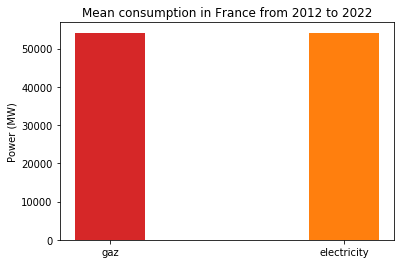

In [11]:
# plot of distribution between gaz and electricity 
mean_df = data_hh[columns_to_describe[:2]].mean()

powers = list(mean_df)
labels = ['gaz', 'electricity']
colors = ['tab:red', 'tab:orange']

fig, ax = plt.subplots()
ax.bar(labels, powers, color=colors, width=0.3)

ax.set_ylabel('Power (MW)')
ax.set_title('Mean consumption in France from 2012 to 2022')

plt.show()

En France, la part de gaz et d'électricité sont équivalentes avec environ 54 GW chacun.

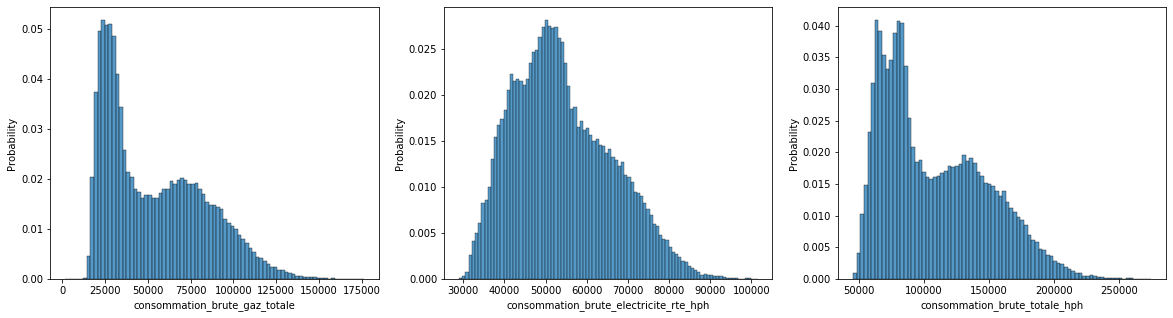

In [12]:
# distribution of gaz, electrictiy and total consumption
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# consommation brute de gaz
sns.histplot(ax=ax[0], data=data_hh, x='consommation_brute_gaz_totale', stat='probability')

# consommaton brute d'electricite
sns.histplot(ax=ax[1], data=data_hh, x='consommation_brute_electricite_rte_hph', stat='probability')

# consommation brute totale
sns.histplot(ax=ax[2], data=data_hh, x='consommation_brute_totale_hph', stat='probability')

plt.show()


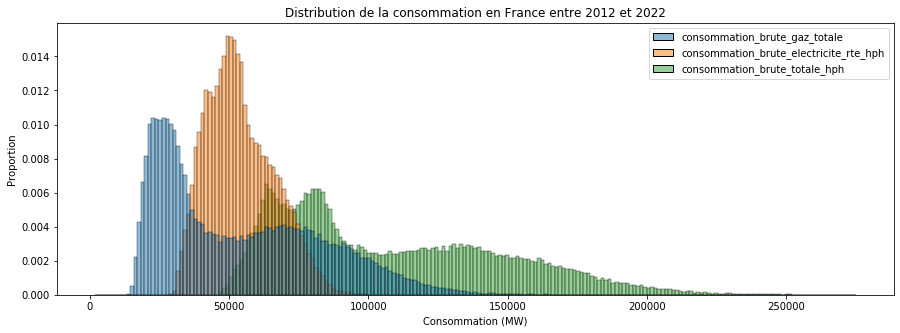

In [13]:
# all the 3 plots on one
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.histplot(ax=ax, data=data_hh[columns_to_describe], stat='proportion')

ax.set_xlabel('Consommation (MW)')
ax.set_title('Distribution de la consommation en France entre 2012 et 2022')
plt.show()

Comme on pouvait le prévoir, la production est un peu moins flexible pour l'électricité. La consommation d'électrcitié reste très centré sur 50 GW.

c:\Users\elkan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\elkan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\elkan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\Users\elkan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\

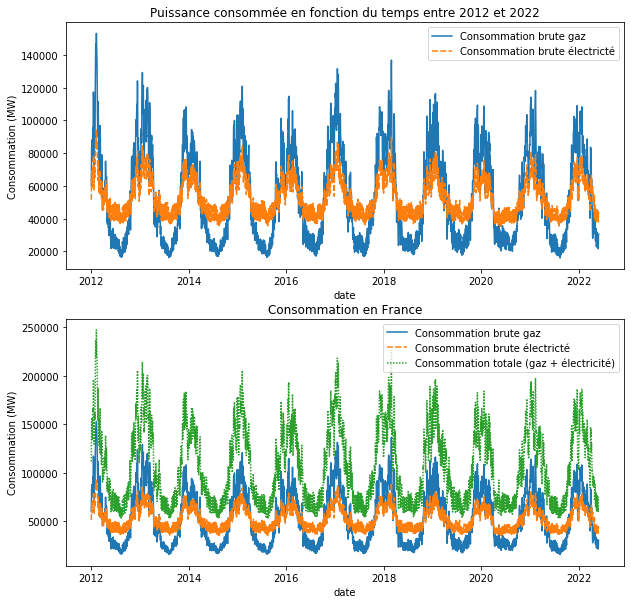

In [14]:
# create a df with daily consumption to analyse on long terme period
daily_conso = data_hh.groupby(by=['date'], sort=True).mean()

# show how it eveolves through time
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.lineplot(ax=ax[0], 
             data=daily_conso[['consommation_brute_gaz_totale', 
                              'consommation_brute_electricite_rte_hph']])
sns.lineplot(ax=ax[1], 
             data=daily_conso[['consommation_brute_gaz_totale', 
                               'consommation_brute_electricite_rte_hph', 
                               'consommation_brute_totale_hph']])

# label title and legend of plot 1 
ax[0].set_ylabel('Consommation (MW)')
ax[0].set_title('Puissance consommée en fonction du temps entre 2012 et 2022')
ax[0].legend(['Consommation brute gaz', 'Consommation brute électricté'])

# label title and legend of plot 2 
ax[1].set_ylabel('Consommation (MW)')
ax[1].set_title('Consommation en France')
ax[1].legend(['Consommation brute gaz', 'Consommation brute électricté', 'Consommation totale (gaz + électricité)'])

# show plots
plt.show()

Ci-dessus, nous avons les reprséentation de la consommation de gaz, d'électricité et de la somme des deux en fonction du temps. 

Premièrement, la consommation est plus importante les périodes de froid (l'hiver) et plus faible lorsqu'il fait plus chaud. 

Deuxièmement, les pics de consommation de gaz et d'électricité de gaz et d'électricité coincident sur ces périodes de grand froid. Cependant, on peut noter que la consommation de gaz est plus failbe que la consommation d'électricité l'été mais que les rôles s'inversent l'hiver. 

A ce point, on peut supposer d'une part, que le rôle compense les limitations de notre production d'électricité. D'auter part, la consommation de gaz serait d'autant plus importante que la production d'électricité serait faible.

Intéressons-nous maintenant à la consommation d'énergie sur une journée. 

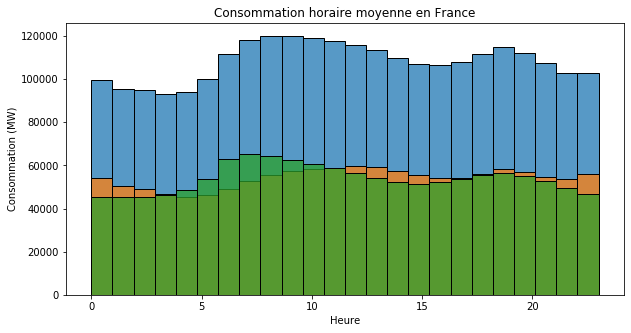

In [15]:
# create a df with consumption regarding only hour
perhour_conso = data_hh.groupby(by='heure').mean()

# create the figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(ax=ax,
             x=[i for i in range(24)], 
             weights=list(perhour_conso.consommation_brute_totale_hph), 
             bins=24, 
             legend=True)
sns.histplot(ax=ax,
             x=[i for i in range(24)], 
             weights=list(perhour_conso.consommation_brute_electricite_rte_hph), 
             bins=24, 
             legend=True)
sns.histplot(ax=ax,
             x=[i for i in range(24)], 
             weights=list(perhour_conso.consommation_brute_gaz_totale), 
             bins=24, 
             legend=True)

# title, label
ax.set_ylabel('Consommation (MW)')
ax.set_xlabel('Heure')
ax.set_title('Consommation horaire moyenne en France')
plt.show()


On peut voir que la consommation d'énergie en France connaît deux pics.

Pic de consommation avant 10h. Cause ? 

Pic de consommation (surtout électricité) peu avant 20h: l'heure à laquelle la majorité des francçais rentrent chez eux. 

Intéresson-nous à la consommation d'énergie sur une année. Choisissons par exemple, l'année 2020.

       consommation_brute_gaz_totale  consommation_brute_electricite_rte_hph  \
count                     366.000000                              366.000000   
mean                    50582.494892                            50730.638718   
std                     24313.612674                             9903.710645   
min                     20147.083333                            35257.583333   
25%                     29397.093750                            42961.062500   
50%                     43907.166667                            46619.875000   
75%                     72450.635417                            58681.359375   
max                    108671.208333                            75379.833333   

       consommation_brute_totale_hph  
count                     366.000000  
mean                   101313.278159  
std                     34021.047064  
min                     55560.625000  
25%                     73233.567708  
50%                     90011.656250  
75%   

c:\Users\elkan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\elkan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\elkan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\Users\elkan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\

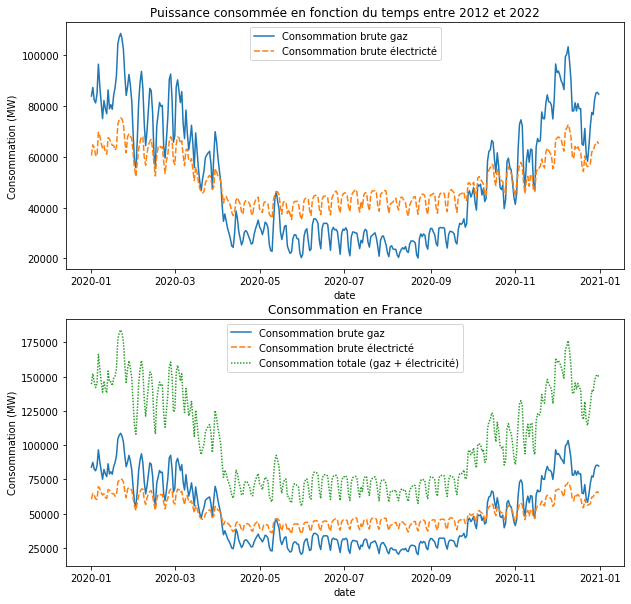

In [22]:
# begining & end of the year 
start = '2020-01-01'
end = '2020-12-31'

# select rows
year_2020 = data_hh.loc[(data_hh.date >= start)
                        & (data_hh.date <= end)] \
                   .groupby(by='date', sort=True) \
                   .mean()

# short descritpion of the df 
print(year_2020[['consommation_brute_gaz_totale',
                 'consommation_brute_electricite_rte_hph', 
                 'consommation_brute_totale_hph']].describe())

# show how it eveolves through time
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.lineplot(ax=ax[0], 
             data=year_2020[['consommation_brute_gaz_totale', 
                             'consommation_brute_electricite_rte_hph']])
sns.lineplot(ax=ax[1], 
             data=year_2020[['consommation_brute_gaz_totale', 
                             'consommation_brute_electricite_rte_hph', 
                             'consommation_brute_totale_hph']])

# label title and legend of plot 1 
ax[0].set_ylabel('Consommation (MW)')
ax[0].set_title('Puissance consommée en fonction du temps entre 2012 et 2022')
ax[0].legend(['Consommation brute gaz', 'Consommation brute électricté'])

# label title and legend of plot 2 
ax[1].set_ylabel('Consommation (MW)')
ax[1].set_title('Consommation en France')
ax[1].legend(['Consommation brute gaz', 'Consommation brute électricté', 'Consommation totale (gaz + électricité)'])

# show plots 
plt.show()

Sur l'année 2020, la France a consommé en moyenne 100 GW d'électricité det de gaz avec tout de même des pics à 184 GW pendant l'hiver. En effet,  la consommation pendant l'hiver explose et particulièrement la consommation de gaz. 

La consommation de gaz. Dans un premier moment, il pourrait être intéressant dans de comparer la consommation de gaz moyenne pendant l'été avec la consommation de gaz moyenne pendant l'hiver. Dans un second moment, il devrait êter intéressant de chercher pourquoi l'écart est si important. Chauffage ? Remplacement de l'électricité par le gaz ? Est-ce vraiment possible ? 

La consommation d'électricité. La consommation d'électricité en France reste à peu près constante, mêmem si on note une augmentation de celle-ci l'hiver. Ainsi, le rapport de la std et de la moyenne est de 0,2. Dans un premier moment, il pourrait être intéressant de comprendre pourquoi la consommation d'électricité fluctue aussi peu comparé au gaz. Dans un second moment, il pourrait êter intéressant de discuter du rôle du nucléaire français tout au long de cette année. 

Fun fact: quelle est la consommation d'une box wi-fi ? De l'ordre de 10W. Or en France, il y a environ 30 millions de ménages. Ainsi, si tous les français coupaient le wifi la journée, on économiserait 0,3 GW d'électricité. Sachant que l'on consomme en moyenne sur l'année 50 GW d'électricité et jusqu'à 75 GW en hiver on économiserait donc 0,6% d'électricité en temps normal et 0,4% lors des pics de consommation. 
Je me pose donc la question suivante: comment les citoyens peuvent-ils participer à l'effort énergétique ? ou tout simplement prendre de bonnes habitudes ? 